Utiliser ad_fuller par exemple pour confirmer que ça s'est bien passé.

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error as mape_loss
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction
import plotly.graph_objects as go
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox


pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)
import warnings
warnings.filterwarnings("ignore")

In [2]:
train= pd.read_csv('train.csv')
features= pd.read_csv('features.csv')
stores= pd.read_csv('stores.csv')

train['Date']= pd.to_datetime(train['Date'])
features['Date']= pd.to_datetime(features['Date'])

train= train.merge(stores).merge(features)

On choisit l'un des stores et on s'intéresse aux ventes hebdomadaires total réalisé par le store. Cela revient à sommer les ventes de tous les départements chaque semaine.

In [3]:
number_store= 1 # Numéro du store dans le dataset. A configurer

train= train.drop(columns=['Dept'])
train= train.groupby(['Store', 'Date'], as_index=False).agg(lambda x : x.sum() if x.name=='Weekly_Sales' else x.head(1))
train= train[train['Store']==number_store]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=['Weekly_Sales']), train[['Date', 'Weekly_Sales']], test_size=0.2, shuffle= False)
y_train.set_index('Date', inplace=True)
y_test.set_index('Date', inplace=True)

# Fonctions utiles

In [5]:
def plot_ys(*series, labels=None):
  nb_series=len(series)
  colors = ['blue', 'red', 'green']
  fig = []
  data = None
  for i in range(nb_series):
    fig.append(px.line(series[i]))
    if labels is not None:
      fig[i].update_traces(name= labels[i])
    fig[i].update_traces(line_color=colors[i])
    if data==None:
      data = fig[i].data
    else:
      data = data + fig[i].data
  figFinal = go.Figure(data = data)
  figFinal.show()

In [6]:
from scipy import stats
import numpy as np
from scipy.stats import boxcox
from scipy.special import inv_boxcox

def auto_nonlinear_transformation_dataframe(df, significance_level=0.05):
    # Test de Bartlett pour l'hétéroscédasticité
    _, p_bartlett = stats.bartlett(df['Weekly_Sales'].values, df['Weekly_Sales'].values)

    # Test de Shapiro-Wilk pour la normalité
    _, p_shapiro = stats.shapiro(df['Weekly_Sales'].values)

    transformation_type = 'None'  # Aucune transformation par défaut
    inverse_transform = None

    # Appliquer une transformation logarithmique si la variance augmente significativement
    if p_bartlett < significance_level:
        transformed_df = df.copy()
        transformed_df['Weekly_Sales'] = np.log(df['Weekly_Sales'])
        transformation_type = 'Logarithm'
        inverse_transform = np.exp

    # Appliquer une transformation racine carrée si les résidus ne sont normalement distribués
    elif p_shapiro < significance_level:
        transformed_df = df.copy()
        transformed_df['Weekly_Sales'] = np.sqrt(df['Weekly_Sales'])
        transformation_type = 'Square Root'
        inverse_transform = np.square

    # Appliquer une transformation Box-Cox si nécessaire
    else:
        _, lmbda = stats.boxcox(df['Weekly_Sales'])
        if lmbda != 0:
            transformed_df = df.copy()
            transformed_df['Weekly_Sales'] = boxcox(df['Weekly_Sales'], lmbda)
            transformation_type = 'Box-Cox'
            inverse_transform = lambda x: inv_boxcox(x, lmbda)

    return transformed_df, transformation_type, inverse_transform

# KNeighborsRegressor

Penser aux transformations non linéaires

In [7]:
transformed_df, transformation_type, inverse_transform = auto_nonlinear_transformation_dataframe(y_train)

In [8]:
from sklearn.model_selection import GridSearchCV
from sktime.forecasting.model_selection import SlidingWindowSplitter, ForecastingGridSearchCV

regressor_param_grid = {
    'n_neighbors': [1]
}

forecaster_param_grid = {
    "window_length": [5, 12, 14, 15]
}

regressor = GridSearchCV(KNeighborsRegressor(), param_grid=regressor_param_grid)
forecaster = make_reduction(regressor, window_length=15, strategy="direct")

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=20)
gscv = ForecastingGridSearchCV(
    forecaster, strategy="refit", cv=cv, param_grid=forecaster_param_grid
)

In [9]:
fh = np.arange(1,len(y_test)+1)

gscv.fit(transformed_df, fh=fh)
y_pred = inverse_transform(gscv.predict(fh))
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mape_loss(y_test, y_pred)

0.04248812270420617

# RandomForestRegressor

In [10]:
from sklearn.model_selection import GridSearchCV
from sktime.forecasting.model_selection import SlidingWindowSplitter, ForecastingGridSearchCV

regressor_param_grid = {
    'n_estimators': [100] # Définir plus de n_estimators en fonction de la puissance de la machine
}

forecaster_param_grid = {
    "window_length": [5, 12, 14, 15]
}

regressor = GridSearchCV(RandomForestRegressor(n_jobs=-1), param_grid=regressor_param_grid)
forecaster = make_reduction(regressor, window_length=15, strategy="direct")

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=20)
gscv = ForecastingGridSearchCV(
    forecaster, strategy="refit", cv=cv, param_grid=forecaster_param_grid
)

In [ ]:
fh = np.arange(1,len(y_test)+1)

gscv.fit(transformed_df, fh=fh)
y_pred = inverse_transform(gscv.predict(fh))
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mape_loss(y_test, y_pred)

# ARIMA

Un modèle ARIMA ne modélise pas la saisonnalité d'une Time Series, il faut donc s'en débarasser dans un premier lieu.

In [12]:
data= train[['Date', 'Weekly_Sales']]
data= data.set_index('Date')

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
out = seasonal_decompose(data)

In [15]:
x= out.observed-out.seasonal
x= pd.DataFrame(x, columns=['Weekly_Sales'])

In [24]:
transformed_df, transformation_type, inverse_transform = auto_nonlinear_transformation_dataframe(x)

In [25]:
best_p, best_d, best_q= None, None, None
best_aicc= np.inf

for p in [1,2,3,4]:
    for q in [0, 1, 2]:
        for d in [0, 1, 2]:
            mod = ARIMA(transformed_df, order=(p,d,q))
            res = mod.fit()

            if(res.aicc)<best_aicc:
                best_aicc= res.aicc
                best_p, best_d, best_q= p,d,q    

# print("best_aicc : {}, p : {}, d : {}, q : {}".format(best_aicc, best_p, best_d, best_q))

best_aicc : 2008.3279810487084, p : 2, d : 1, q : 1


In [27]:
mod = ARIMA(transformed_df, order=(best_p, best_d, best_q))
res = mod.fit()

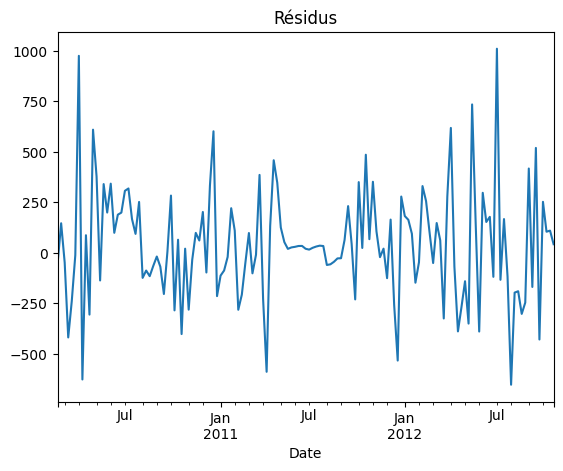

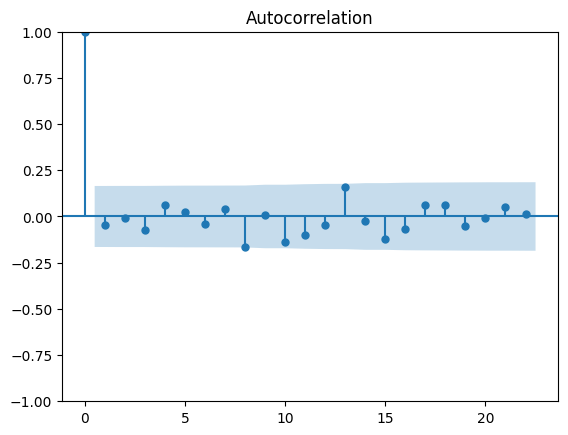

In [28]:
residus = res.resid[2:]
residus.plot(title="Résidus")
plot_acf(residus)
plt.show()

In [31]:
y_pred = res.forecast(len(y_test))
y_pred.index= y_test.index
y_pred= inverse_transform(y_pred)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mape_loss(y_test, y_pred)

0.054283653452410534

# SARIMA

Source : https://blog.statoscop.fr/timeseries-4.html

In [ ]:
import itertools
from statsmodels.tsa.statespace.sarimax import *
from tqdm import tqdm

# on génère toutes les combinaisons possibles des paramèters
p = d = q = P = D = Q = range(2)
params = list(itertools.product(p, d, q, P, D, Q))

# on initialise nos paramètres optimaux
tmp_model = None
best = {}
best['aic'] = {'pdq': None, 'PDQ':None, 'model':None, 'aic':np.inf, 'bic':np.inf}

for p,d,q,P,D,Q in tqdm(params):
    tmp_model = SARIMAX(transformed_df,
                        order = (p,d,q),
                        seasonal_order = (P,D,Q,52),
                        enforce_stationarity=True,
                        enforce_invertibility=True)
    res = tmp_model.fit(disp=False)

    if res.aic < best['aic']['aic']:
        best['aic']['aic'] = res.aic
        best['aic']['bic'] = res.bic
        best['aic']['pdq'] = (p,d,q)
        best['aic']['PDQ'] = (P,D,Q)
        best['aic']['model'] = res

print(f"Modèle retenu selon le critère AIC : SARIMA{best['aic']['pdq']}{best['aic']['PDQ']}12 - AIC:{best['aic']['aic']} - BIC:{best['aic']['bic']}")

In [36]:
final_model = SARIMAX(transformed_df, order = best['aic']['pdq'], seasonal_order = (P,D,Q,52), enforce_stationarity=True, enforce_invertibility=True)
res= final_model.fit(disp= False)

In [37]:
y_pred = res.forecast(len(y_test))
y_pred.index= y_test.index
y_pred= inverse_transform(y_pred)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mape_loss(y_test, y_pred)

0.05411963484501927

# Auto-Arima

In [40]:
from pmdarima.arima import auto_arima

In [44]:
stepwise_model = auto_arima(transformed_df, start_p=1, start_q=1,
                           max_p=3, max_q=3, d=1,
                           start_P=0, start_Q=0, max_P=3,
                           max_Q=3, D=1, m=52,
                           seasonal=True,
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True) 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[52]             : AIC=1350.428, Time=2.05 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1393.182, Time=0.18 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=1375.532, Time=20.58 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=1342.142, Time=34.24 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=1349.582, Time=0.63 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=inf, Time=53.67 sec
 ARIMA(0,1,1)(0,1,2)[52]             : AIC=inf, Time=58.36 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=1342.941, Time=28.06 sec
 ARIMA(0,1,1)(1,1,2)[52]             : AIC=inf, Time=120.28 sec
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=1389.325, Time=10.53 sec
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=1343.760, Time=54.48 sec
 ARIMA(0,1,2)(0,1,1)[52]             : AIC=1343.576, Time=38.19 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=1374.829, Time=20.01 sec
 ARIMA(1,1,2)(0,1,1)[52]             : AIC=1344.842, Time=44.22 sec
 ARIMA(0,1,1)(0,1,1)[5

In [51]:
stepwise_model.fit(transformed_df)

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 52),
      suppress_warnings=True, with_intercept=False)

In [108]:
future_forecast, ci = stepwise_model.predict(n_periods=len(y_test), return_conf_int=True,alpha=0.05)

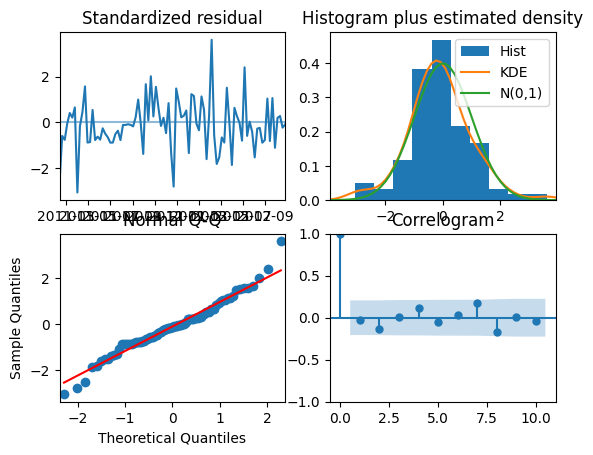

In [102]:
stepwise_model.plot_diagnostics()
plt.show()

In [110]:
future_forecast = pd.DataFrame(future_forecast, columns=['Weekly_Sales'])
future_forecast.index = y_test.index

In [113]:
y_pred= inverse_transform(future_forecast)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mape_loss(y_test, y_pred)

0.0658465274538652

# Naive Forecaster

In [ ]:
fh = np.arange(1,len(y_test)+1)
forecaster = NaiveForecaster(strategy="mean")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mape_loss(y_pred, y_test)

0.043722059980694256